# Descripción del conjunto de datos

Debe haber una columna de predicción por imagen, y las etiquetas se representan como números enteros que corresponden cada uno a una parte del cuerpo contenida en el conjunto de datos:

* Abdomen = 0
* Tobillo = 1
* Columna cervical = 2
* Tórax = 3
* Clavículas = 4
* Codo = 5
* Pies = 6
* Dedos = 7
* Antebrazo = 8
* Mano = 9
* Cadera = 10
* Rodilla = 11
* Pierna = 12
* Columna lumbar = 13
* Otros = 14
* Pelvis = 15
* Hombro = 16
* Senos paranasales = 17
* Cráneo = 18
* Muslo = 19
* Columna torácica = 20
* Muñeca = 21

*Nota*: Otros indica si la muestra contiene imágenes no radiográficas que a veces se colocan erróneamente en el sistema PACS como radiografías (por ejemplo, esofagograma, densitometría).

### Archivos

* train.csv - el conjunto de entrenamiento. Contiene el SOPInstanceUID y la información del objetivo.
* sample_submission.csv - un archivo de presentación de muestras en el formato correcto. Contiene SOPInstanceUID para el conjunto de test.

### Columnas

* SOPInstanceUID- Cada SOPInstanceUID corresponde a una imagen única.
* Target - La etiqueta asignada a cada muestra.

# SetUp

In [2]:
!pip install pydicom


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pandas as pd
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import warnings
import random

warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")


In [5]:
# Rutas a los directorios
train_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train'
test_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/test'
train_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train.csv'
sample_submission_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/sample_submission.csv'

# Cargar los datos de entrenamiento
train_df = pd.read_csv(train_csv)

# Visualizar algunas filas del DataFrame
train_df


SOPInstanceUID  Target
0     1.2.826.0.1.3680043.8.498.10062189329714053601...      14
1     1.2.826.0.1.3680043.8.498.53411283183733547704...       3
2     1.2.826.0.1.3680043.8.498.12955484645689261949...       3
3     1.2.826.0.1.3680043.8.498.10408703585974384892...       3
4     1.2.826.0.1.3680043.8.498.30255106562321206269...       9
...                                                 ...     ...
1273  1.2.826.0.1.3680043.8.498.61418411983294329010...       3
1274  1.2.826.0.1.3680043.8.498.10229701585590529671...       6
1275  1.2.826.0.1.3680043.8.498.67348831696239827753...      11
1276  1.2.826.0.1.3680043.8.498.10105498531842222086...       3
1277  1.2.826.0.1.3680043.8.498.29104461378240611135...      11

[1278 rows x 2 columns]

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1278 non-null   object
 1   Target          1278 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.1+ KB


#Exploracion de imagenes

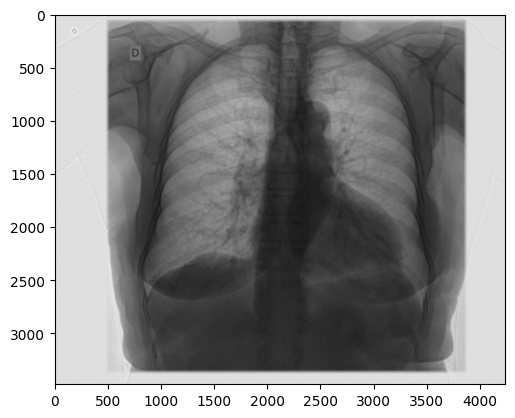

In [7]:
def show_dicom_image_single(file_path):
    dicom = pydicom.dcmread(file_path)
    plt.imshow(dicom.pixel_array, cmap='gray')
    plt.show()

#  imagen de ejemplo
example_image_path = os.path.join(train_dir, train_df.iloc[2]['SOPInstanceUID'] + '.dcm')
show_dicom_image_single(example_image_path)

In [7]:

def show_dicom_image_multi(file_path, ax):
    dicom = pydicom.dcmread(file_path)
    ax.imshow(dicom.pixel_array, cmap='gray')
    ax.axis('off')  # Desactivar ejes

# Seleccionar 25 imágenes al azar
random_indices = random.sample(range(len(train_df)), 25)
random_image_paths = [os.path.join(train_dir, train_df.iloc[i]['SOPInstanceUID'] + '.dcm') for i in random_indices]

# Crear una figura y ejes para una matriz de 5x5
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Mostrar cada imagen en su correspondiente subgráfico
for ax, image_path in zip(axes.flat, random_image_paths):
    show_dicom_image_multi(image_path, ax)

# Ajustar el espacio entre subgráficos
plt.tight_layout()
plt.show()


# Procesamiento de imagenes

Ajuste de dimensiones y parametros. Aca se pueden agregar otras transformaciones y filtros para mejorar las siluetas. Tambien aplicar transformaciones que vimos en clase para reducir la dimensionalidad. Revisar

In [8]:
#Numero maximo de imagenes para entrenar el modelo
max = 1278
#1278

In [9]:

def preprocess_image_2c(file_path, img_size):
    dicom = pydicom.dcmread(file_path)
    img = dicom.pixel_array
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalización
    return img

def preprocess_image(file_path, img_size):
    dicom = pydicom.dcmread(file_path)
    img = dicom.pixel_array

    # Escalar los valores de píxeles a un rango conocido, por ejemplo [0, 255]
    img = img.astype(np.float32)
    img_min = img.min()
    img_max = img.max()
    img = (img - img_min) / (img_max - img_min) * 255.0

    # Convertir a uint8 para aplicar la ecualización del histograma
    img = img.astype(np.uint8)

    # Aplicar CLAHE en la imagen en escala de grises
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Aplicar filtro bilateral para eliminar el ruido mientras se preservan los bordes
    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

    # Convertir a tres canales (duplicando el canal en escala de grises)
    img = np.stack([img] * 3, axis=-1)

    # Redimensionar la imagen al tamaño deseado
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalización a rango [0, 1]

    return img

# Preprocesar una imagen de ejemplo
preprocessed_img = preprocess_image_2c(example_image_path, 224)
plt.imshow(preprocessed_img, cmap='gray')
plt.show()


Procesamiento batch de todas las imagenes y division en test y train

In [10]:
import os
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import zipfile
import pydicom
import warnings

# Suprimir los warnings
warnings.filterwarnings('ignore')

def process_images(num_images, save_path, train_df, train_dir):
    img_size = 224
    X = []
    y = []

    # Crear el archivo ZIP directamente
    zip_path = os.path.join(save_path, "processed_images_train_2.zip")
    zipf = zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED)  # 'w' para sobrescribir el archivo existente

    # Utiliza tqdm directamente en el bucle for con iterrows()
    pbar = tqdm(total=min(num_images, len(train_df)), desc="Procesando imágenes")
    for idx, row in train_df.iterrows():
        if idx >= num_images:
            break

        img_path = os.path.join(train_dir, row['SOPInstanceUID'] + '.dcm')
        img = preprocess_image(img_path, img_size)
        X.append(img)
        y.append(row['Target'])

        # Convertir la imagen a uint8 y guardar en el archivo ZIP
        img_uint8 = (img * 255).astype(np.uint8)
        _, img_encoded = cv2.imencode('.png', img_uint8)
        zipf.writestr(f"{row['SOPInstanceUID']}.png", img_encoded.tobytes())

        pbar.update(1)

    pbar.close()
    zipf.close()

    X = np.array(X)
    y = np.array(y)
    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

# Especificar la cantidad de imágenes a procesar

save_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/'
num_images_to_process = max

X_train, X_val, y_train, y_val = process_images(num_images_to_process, save_path, train_df, train_dir)


Procesando imágenes: 100%|██████████| 1278/1278 [2:53:13<00:00,  8.13s/it]


Carga de imagenes desde el zip con las imagenes procesadas

In [11]:
import zipfile

def load_images_from_zip(zip_path, train_df):
    img_size = 224
    X = []
    y = []

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        for row in tqdm(train_df.itertuples(), total=len(train_df), desc="Cargando imágenes"):
            img_name = f"{row.SOPInstanceUID}.png"
            if img_name in zipf.namelist():
                with zipf.open(img_name) as img_file:
                    img_array = np.frombuffer(img_file.read(), np.uint8)
                    img = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

                    if img is not None:
                        img = img.astype(np.float32) / 255.0
                        X.append(img)
                        y.append(row.Target)

    X = np.array(X)
    y = np.array(y)
    return X, y

# Especificar la ruta del archivo ZIP y cargar las imágenes
save_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/'
zip_path = os.path.join(save_path, "processed_images_train.zip")
X, y = load_images_from_zip(zip_path, train_df)

# Codificar las etiquetas
le = LabelEncoder()
y = le.fit_transform(y)

# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Cargando imágenes: 100%|██████████| 1278/1278 [00:10<00:00, 118.19it/s]


Visualizacion de imagenes de train procesadas

Max value: 0.9882353 Min value: 0.05490196
Max value: 0.99607843 Min value: 0.0627451
Max value: 0.9764706 Min value: 0.03137255
Max value: 0.972549 Min value: 0.02745098
Max value: 1.0 Min value: 0.1254902
Max value: 0.99215686 Min value: 0.08235294
Max value: 0.99215686 Min value: 0.08627451
Max value: 0.99607843 Min value: 0.08627451
Max value: 0.9882353 Min value: 0.24705882
Max value: 0.98039216 Min value: 0.078431375
Max value: 1.0 Min value: 0.023529412
Max value: 0.98039216 Min value: 0.14509805
Max value: 0.96862745 Min value: 0.1254902
Max value: 0.9647059 Min value: 0.07058824
Max value: 1.0 Min value: 0.14509805
Max value: 0.99215686 Min value: 0.07450981
Max value: 1.0 Min value: 0.07450981
Max value: 0.9882353 Min value: 0.05882353
Max value: 0.9882353 Min value: 0.03529412
Max value: 0.9843137 Min value: 0.101960786
Max value: 0.99215686 Min value: 0.0627451
Max value: 0.9764706 Min value: 0.03137255
Max value: 1.0 Min value: 0.03137255
Max value: 0.9019608 Min value: 0.

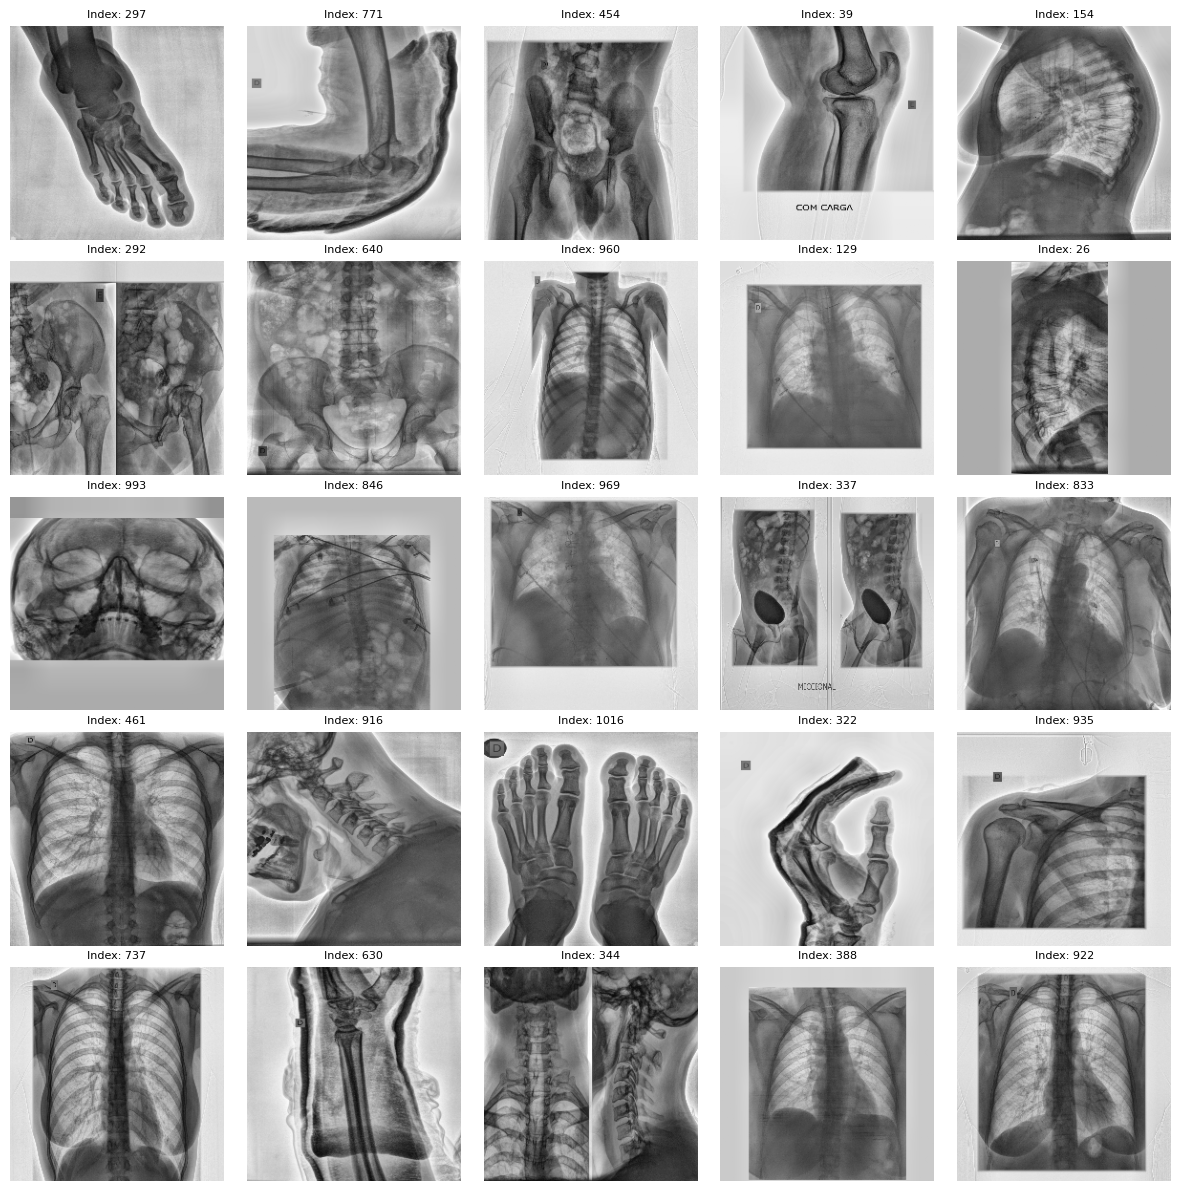

In [12]:
def show_random_images(X, num_images=25):
    # Asegurarse de que num_images no exceda el número de imágenes en X
    num_images = min(X.shape[0], num_images)
    # Seleccionar índices aleatorios
    indices = np.random.choice(X.shape[0], num_images, replace=False)

    # Configurar la figura y los ejes
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for ax, idx in zip(axes.flat, indices):
        image = X[idx]
        print("Max value:", image.max(), "Min value:", image.min())  # Imprimir valores máximos y mínimos

        # Normalizar sólo si es necesario
        if image.max() > 1:
            image = image.astype(float) / 255.0

        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        ax.set_title(f'Index: {idx}', fontsize=8)
        ax.axis('off')

    plt.show()

# Asegúrate de que X_train o X_val esté definido y contenga datos.
show_random_images(X_train, num_images=25)


# Modelo

### Entrenamiento

Usamos el modelo ResNet50 preentrenado con entrada de tres canales. Estamos agregando un canal vacio para poder usar este modelo. Ojo, revisar esto, podemos optar por usar modelos bidimensionales.** Hay que hacer un research a ver que modelo es mas conveniente**. Agregar mas metricas de performance.

ResNet, que significa "Redes Residuales", es una arquitectura de red neuronal convolucional (CNN) desarrollada por Microsoft Research en 2015. ResNet introdujo el concepto de "skip connections" o "conexiones residuales", que permiten que las redes neuronales profundas se vuelvan aún más profundas sin sufrir el problema de degradación de la precisión.


'Un "epoch" en el contexto del entrenamiento de modelos de aprendizaje automático se refiere a una pasada completa de todos los ejemplos de entrenamiento a través del modelo. En otras palabras, durante un epoch, el modelo ve todos los ejemplos de entrenamiento una vez y ajusta sus pesos en consecuencia para mejorar su desempeño.

Durante el entrenamiento de un modelo, los datos de entrenamiento se dividen en lotes de un tamaño específico (por ejemplo, 32, 64, etc.). Durante cada epoch, el modelo pasa por todos los lotes de entrenamiento, calcula la pérdida y ajusta sus pesos utilizando un algoritmo de optimización, como el descenso del gradiente estocástico (SGD) o Adam. Después de pasar por todos los lotes de entrenamiento, se completa un epoch y el modelo pasa al siguiente epoch.

El número de epochs que se especifica en el entrenamiento del modelo indica cuántas veces se repetirá este proceso completo de pasar por todos los ejemplos de entrenamiento. A menudo, se requieren múltiples epochs para que el modelo aprenda patrones complejos en los datos y mejore su rendimiento. Sin embargo, es importante evitar el sobreajuste al entrenar demasiado tiempo, por lo que es común utilizar técnicas como el early stopping para detener el entrenamiento una vez que el rendimiento en el conjunto de validación deja de mejorar.'

Epoch 1/15
32/32 [==============================] - 311s 10s/step - loss: 2.5210 - accuracy: 0.4022 - val_loss: 1.9365 - val_accuracy: 0.5117
Epoch 2/15
32/32 [==============================] - 307s 10s/step - loss: 2.0971 - accuracy: 0.4716 - val_loss: 1.8813 - val_accuracy: 0.5156
Epoch 3/15
32/32 [==============================] - 307s 10s/step - loss: 1.9527 - accuracy: 0.4843 - val_loss: 1.8424 - val_accuracy: 0.5273
Epoch 4/15
32/32 [==============================] - 304s 10s/step - loss: 1.9052 - accuracy: 0.4912 - val_loss: 1.6798 - val_accuracy: 0.5273
Epoch 5/15
32/32 [==============================] - 298s 9s/step - loss: 1.8325 - accuracy: 0.5098 - val_loss: 1.6477 - val_accuracy: 0.5625
Epoch 6/15
32/32 [==============================] - 305s 10s/step - loss: 1.7476 - accuracy: 0.5274 - val_loss: 1.5968 - val_accuracy: 0.5469
Epoch 7/15
32/32 [==============================] - 265s 8s/step - loss: 1.7022 - accuracy: 0.5294 - val_loss: 1.6055 - val_accuracy: 0.5352
Epoch 8/

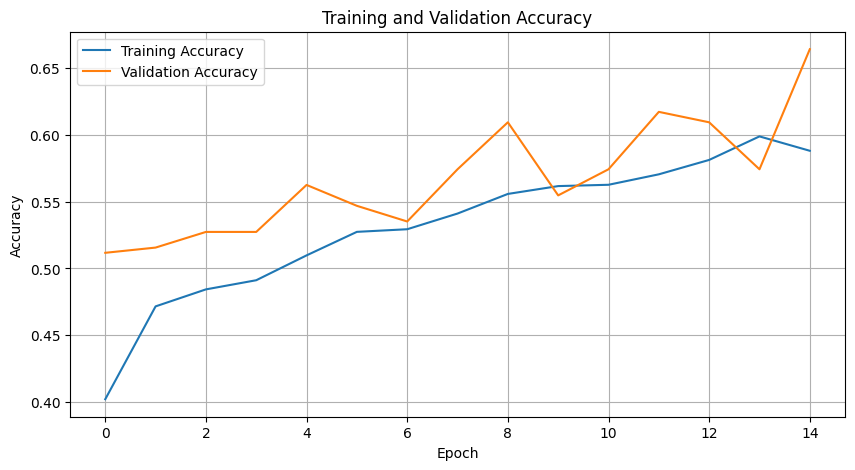

In [13]:
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Construcción del modelo
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(22, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilación del modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback para detener el entrenamiento temprano si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamiento del modelo con las capas congeladas
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[early_stopping])

# Descongelar las últimas capas del modelo base
for layer in base_model.layers[-3:]:
    layer.trainable = True

# Re-compilar el modelo con una tasa de aprendizaje reducida
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ajuste fino del modelo
history_finetune = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32, callbacks=[early_stopping])

# Evaluar el modelo después del ajuste fino
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy after Fine-Tuning: {val_accuracy * 100:.2f}%')

# Graficar los resultados del entrenamiento enfocándose en el Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  # Opcional: añadir una cuadrícula para mejor visualización
plt.show()


### Analisis de imagenes del sample_sumission y procesamiento

Analisis y normalizacion de images de test

In [14]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import zipfile
import cv2


test_df = pd.read_csv(sample_submission_csv)

# Crear un archivo ZIP para guardar las imágenes
save_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/'
zip_path = os.path.join(save_path, "processed_test_images.zip")
zipf = zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED)

# Crear una barra de progreso acumulativo
pbar = tqdm(total=len(test_df), desc="Procesando imágenes de test")

# Procesar todas las imágenes y guardarlas en el archivo ZIP
for idx, row in test_df.iterrows():
    img_path = os.path.join(test_dir, row['SOPInstanceUID'] + '.dcm')
    img = preprocess_image(img_path, 224)

    # Convertir la imagen procesada a formato adecuado y guardar en el ZIP
    img_uint8 = (img * 255).astype(np.uint8)
    _, img_encoded = cv2.imencode('.png', img_uint8)
    zipf.writestr(f"{row['SOPInstanceUID']}.png", img_encoded.tobytes())

    # Actualizar la barra de progreso
    pbar.update(1)

# Cerrar la barra de progreso y el archivo ZIP
pbar.close()
zipf.close()


Procesando imágenes de test: 100%|██████████| 328/328 [41:43<00:00,  7.63s/it]


Carga de imagenes de tes procesadas e imputacion de predicciones

In [15]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import zipfile
import cv2
from keras.models import load_model

# Función para cargar imágenes desde el archivo ZIP
def load_images_from_zip(zip_path, test_df):
    img_size = 224
    X_test = []

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        for row in tqdm(test_df.itertuples(), total=len(test_df), desc="Cargando imágenes de test"):
            img_name = f"{row.SOPInstanceUID}.png"
            if img_name in zipf.namelist():
                with zipf.open(img_name) as img_file:
                    img_array = np.frombuffer(img_file.read(), np.uint8)
                    img = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

                    if img is not None:
                        img = cv2.resize(img, (img_size, img_size))  # Redimensionar la imagen
                        if len(img.shape) == 2:  # Si la imagen es en escala de grises, convertir a RGB
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                        img = img.astype(np.float32) / 255.0  # Normalizar la imagen
                        X_test.append(img)

    X_test = np.array(X_test)
    return X_test


# Especificar la ruta del archivo ZIP y cargar las imágenes
save_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/'
zip_path = os.path.join(save_path, "processed_test_images_2.zip")
X_test = load_images_from_zip(zip_path, test_df)

# Verificar la forma de las imágenes cargadas
print("Shape of X_test:", X_test.shape)  # Debería ser (num_samples, 224, 224, 3)


# Predecir las etiquetas
predictions = []
for img in tqdm(X_test, desc="Aplicando predicciones"):
    img_expanded = np.expand_dims(img, axis=0)  # Expandir dimensiones para cumplir con la entrada del modelo
    pred = model.predict(img_expanded, verbose=0)  # verbose=0 para suprimir la salida
    pred_label = np.argmax(pred, axis=1)
    predictions.append(pred_label[0])

# Asegurarse de que las predicciones están en el formato correcto
predictions = np.array(predictions)

# Preparar el DataFrame de submission
submission_df = test_df.copy()
submission_df['Target'] = predictions
submission_df.to_csv('/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/GitHub/GitHub_Repositorios/dp4_team2/sample_submission_cris_3.csv', index=False)

# Mostrar el DataFrame de submission
submission_df


Cargando imágenes de test: 100%|██████████| 328/328 [00:01<00:00, 283.07it/s]


Shape of X_test: (328, 224, 224, 3)


Aplicando predicciones: 100%|██████████| 328/328 [01:59<00:00,  2.74it/s]


SOPInstanceUID  Target
0    1.2.826.0.1.3680043.8.498.75932240489221075589...       3
1    1.2.826.0.1.3680043.8.498.80518330963406833915...       3
2    1.2.826.0.1.3680043.8.498.97413731471864060627...       3
3    1.2.826.0.1.3680043.8.498.98229201581139590153...       3
4    1.2.826.0.1.3680043.8.498.84551354213532970228...       3
..                                                 ...     ...
323  1.2.826.0.1.3680043.8.498.60964782211363234805...       3
324  1.2.826.0.1.3680043.8.498.90617059056548212763...       0
325  1.2.826.0.1.3680043.8.498.77795747668217965858...       3
326  1.2.826.0.1.3680043.8.498.83898837859028979514...       3
327  1.2.826.0.1.3680043.8.498.76482195481290376937...       3

[328 rows x 2 columns]

# Analisis

In [16]:
#Distribucion de predicciones

grouped = submission_df.groupby('Target').size().reset_index(name='Frecuencia')

# Diccionario que mapea los números de la columna 'Target' con los nombres de partes del cuerpo
id = {
    0: 'Abdomen',
    1: 'Tobillo',
    2: 'Columna cervical',
    3: 'Tórax',
    4: 'Clavículas',
    5: 'Codo',
    6: 'Pies',
    7: 'Dedos',
    8: 'Antebrazo',
    9: 'Mano',
    10: 'Cadera',
    11: 'Rodilla',
    12: 'Pierna',
    13: 'Columna lumbar',
    14: 'Otros',
    15: 'Pelvis',
    16: 'Hombro',
    17: 'Senos paranasales',
    18: 'Cráneo',
    19: 'Muslo',
    20: 'Columna torácica',
    21: 'Muñeca'
}

# Nuevas columnas y agrupaciones
grouped['Seccion'] = grouped['Target'].map(id)
grouped_sorted = grouped.sort_values(by='Frecuencia', ascending=False)
total = grouped_sorted['Frecuencia'].sum()
grouped_sorted['%'] = (grouped_sorted['Frecuencia'] / total) * 100


grouped_sorted


Target  Frecuencia           Seccion          %
3       3         294             Tórax  89.634146
0       0           9           Abdomen   2.743902
1       1           7           Tobillo   2.134146
4       6           7              Pies   2.134146
9      16           5            Hombro   1.524390
7      14           2             Otros   0.609756
2       2           1  Columna cervical   0.304878
5       9           1              Mano   0.304878
6      12           1            Pierna   0.304878
8      15           1            Pelvis   0.304878

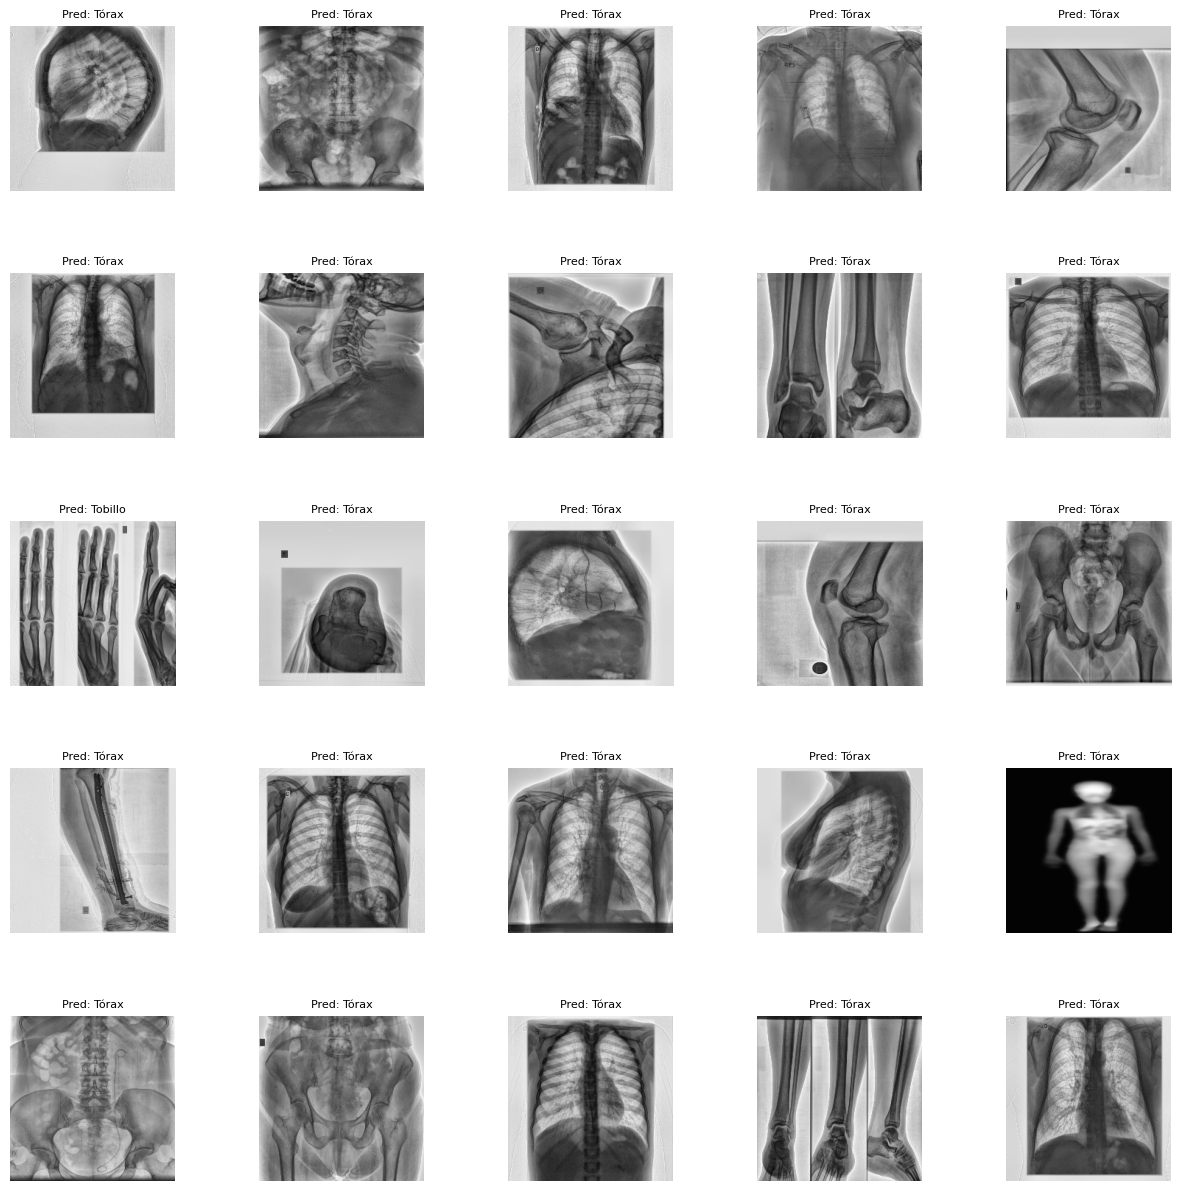

In [17]:
import matplotlib.pyplot as plt

def show_predictions_with_images(submission_df, zip_path, num_images=25):
    # Asegurarse de que num_images no exceda el número de imágenes en submission_df
    num_images = min(len(submission_df), num_images)

    # Seleccionar índices aleatorios
    indices = np.random.choice(len(submission_df), num_images, replace=False)

    # Crear una figura para mostrar las imágenes
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # Mapa de id a secciones del cuerpo
    id_to_section = {
        0: 'Abdomen', 1: 'Tobillo', 2: 'Columna cervical', 3: 'Tórax', 4: 'Clavículas', 5: 'Codo', 6: 'Pies', 7: 'Dedos',
        8: 'Antebrazo', 9: 'Mano', 10: 'Cadera', 11: 'Rodilla', 12: 'Pierna', 13: 'Columna lumbar', 14: 'Otros', 15: 'Pelvis',
        16: 'Hombro', 17: 'Senos paranasales', 18: 'Cráneo', 19: 'Muslo', 20: 'Columna torácica', 21: 'Muñeca'
    }

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        for ax, idx in zip(axes.flat, indices):
            row = submission_df.iloc[idx]
            img_name = f"{row['SOPInstanceUID']}.png"

            with zipf.open(img_name) as img_file:
                img_array = np.frombuffer(img_file.read(), np.uint8)
                img = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

                if img is not None:
                    if len(img.shape) == 2:  # Si la imagen es en escala de grises, convertir a RGB
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                    ax.imshow(img)
                    pred_section = id_to_section.get(row['Target'], "Desconocido")
                    ax.set_title(f'Pred: {pred_section}', fontsize=8)
                    ax.axis('off')

    plt.show()

# Ruta al archivo ZIP de imágenes procesadas
zip_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_test_images.zip'

# Mostrar las imágenes con predicciones
show_predictions_with_images(submission_df, zip_path, num_images=25)
